<h1 style='font-size: 40px'>Examples using Dionysus and Ripser packages to compute Persistent (Co)homology for time series data using Pandas and PySpark</h1>

# Computing Betti numbers with [Dionysus](http://www.mrzv.org/software/dionysus2/) 

## Pandas

In [1]:
from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import dionysus
import matplotlib.pyplot as plt
import random
import itertools
from functools import reduce

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

## Define helper functions

In [2]:
def rolling_window(a, window):
    '''
    Take in an array and return array of rolling windows of specified length
    
    Parameters:
    - a: numpy array that will be windowed
    - window: integer that will be the length of the window
    
    Returns:
    - a_windowed: array where each entry is an array of length window
    '''
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    a_windowed = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_windowed

In [3]:
def time_series_to_point_cloud(time_series, dimension_embed=2):
    '''
    Convert a time series into a point cloud in the dimension specified by dimension_embed
    
    Parameters:
    - time_series: numpy array of time series values
    - dimension_embed: dimension of Euclidean space in which to embed the time series into by taking windows of dimension_embed length,
        e.g. if the time series is [t_1,...,t_n] and dimension_embed is 2, then the point cloud would be [(t_0, t_1), (t_1, t_2),...,(t_(n-1), t_n)]
        
    Returns:
    - point_cloud: collection of points embedded into Euclidean space of dimension = dimension_embed, constructed
    in the manner explained above
    '''

    assert len(time_series) >= dimension_embed, 'dimension_embed larger than length of time_series'
    
    # time series to float type
    time_series = np.array(time_series)
    time_series = time_series.astype(float)

    # compute point cloud
    point_cloud = rolling_window(a=time_series, window=dimension_embed)
    
    return np.array(point_cloud)

In [4]:
def create_epsilon_range(n=100):
    return np.array([y*float(1/n) for y in range(n)])

In [251]:
def point_cloud_to_persistent_homology(point_cloud, epsilon_range, max_simplex_dim):
    epsilon_range = np.array(epsilon_range)
    
    point_cloud = np.array(point_cloud)
    
    # take unique points in the point cloud only
    point_cloud = [list(x) for x in set(tuple(x) for x in point_cloud)]
    
    # compute distance matrix
    distance_mtx = distance_matrix(x=point_cloud, y=point_cloud, p=2)
    
    # find max distance between points
    max_distance = distance_mtx.max()
    
    # scale epsilon_range
    epsilon_range = epsilon_range*(max_distance**2)

    # build filtration with fill_rips
    filtration = dionysus.fill_rips(np.array(point_cloud), k=max_simplex_dim, r=max_distance**2)
    
    # calculate persistent homology
    persistence = dionysus.homology_persistence(filtration)
    
    # initialize persistence diagrams
    diagrams = dionysus.init_diagrams(persistence, filtration)
    
    ep_ran_len = len(epsilon_range)
    
    homology = {dimension: np.zeros(ep_ran_len).tolist() for dimension in range(max_simplex_dim)}

    for dimension, diagram in enumerate(diagrams):
        if dimension < max_simplex_dim and len(diagram) > 0:
            homology[dimension] = np.array([np.array(((epsilon_range >= point.birth) & (epsilon_range <= point.death)).astype(int)) 
                                        for point in diagram
                                       ]).sum(axis=0).tolist()
        
    return homology

In [6]:
def time_series_to_persistent_homology(time_series, epsilon_range, max_simplex_dim):
    '''
    Wrapper function that takes in a time series and outputs
    the persistent homology object, along with other
    auxiliary objects.
    
    Parameters: 
    - time_series: Numpy array of time series values
    - epsilon_range: Numpy array of epsilon values between 0 and 1 at which to extract betti numbers.
    - max_simplex_dim: Integer denoting the maximum dimension of simplexes to create in filtration
    
    Returns:
    - homology: dictionary with keys in range(max_simplex_dim) and, the value hom[i] is an array of length 
    equal to len(epsilon_range) containing the betti numbers of the i-th homology groups for the Rips filtration
    '''
    
    # create point cloud from time series
    point_cloud = time_series_to_point_cloud(time_series, dimension_embed=max_simplex_dim)

    homology = point_cloud_to_persistent_homology(point_cloud=point_cloud, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim)
    return homology

In [7]:
def betti_numbers_df(df, epsilon_range, max_simplex_dim, order_col, channels):   
    # compute homology
    hom_dict = {
      channel: time_series_to_persistent_homology(time_series=df[channel].values, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim)
      for channel in channels
    }
    
    output_hom_dict = {
        'betti_{DIM}_'.format(DIM=dim) + channel : hom_dict[channel][dim]
        for (channel, dim) in itertools.product(channels, range(max_simplex_dim))
    }
  
    return pd.DataFrame(data=output_hom_dict).reset_index().rename(columns={'index': 'epsilon'})

In [8]:
def time_series_rolling_betti(df, channels, epsilon_range, max_simplex_dim, window):
    betti_channels = {}
    for channel in channels:
        betti_channels[channel] = [
            time_series_to_persistent_homology(
                time_series=wdw,
                epsilon_range=epsilon_range,
                max_simplex_dim=max_simplex_dim
            )
            for wdw in rolling_window(df[channel].values, window)
        ]
        
        betti_channels[channel] = pd.concat(
            objs=[
                pd.Series(df[channel].index[window-1:], index=df[channel].index[window-1:], name='index'),
                df[channel][window-1:],
                pd.DataFrame(
                    data=betti_channels[channel],
                    index=df[channel].index[window-1:]
                ).rename(columns={n: '{CHANNEL}_betti_'.format(CHANNEL=channel) + str(n) for n in range(max_simplex_dim)})
            ],
            axis=1
        )

    return reduce(lambda left, right: pd.merge(left, right, on='index'), [betti_channels[channel] for channel in channels])

In [9]:
def noisy_sine(n_steps, radial_noise, amp_noise):
    return np.sin([(16*np.pi*x + radial_noise*random.random())/(n_steps) + amp_noise*random.random() for x in range(n_steps)])

## Generate fake data

In [142]:
n_steps = 30
rrand = [20, 30, 10, 60]
alpha = [0.6, 0.8, 0.2, 0.9]

d1 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[0], amp_noise=alpha[0]),
    't2': noisy_sine(n_steps, radial_noise=rrand[1], amp_noise=alpha[1]),
    'id': 1,
    'index': range(n_steps)
}

d2 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[2], amp_noise=alpha[2]),
    't2': noisy_sine(n_steps, radial_noise=rrand[3], amp_noise=alpha[3]),
    'id': 2,
    'index': range(n_steps)
}

In [143]:
data = pd.concat(objs=[pd.DataFrame(d1), pd.DataFrame(d2)])

In [144]:
data.shape
data.head()

(60, 4)

,id,index,t1,t2
0,1,0,0.718024,0.622654
1,1,1,0.924457,0.426153
2,1,2,-0.953791,-0.926706
3,1,3,-0.150403,-0.240606
4,1,4,0.694622,0.991994


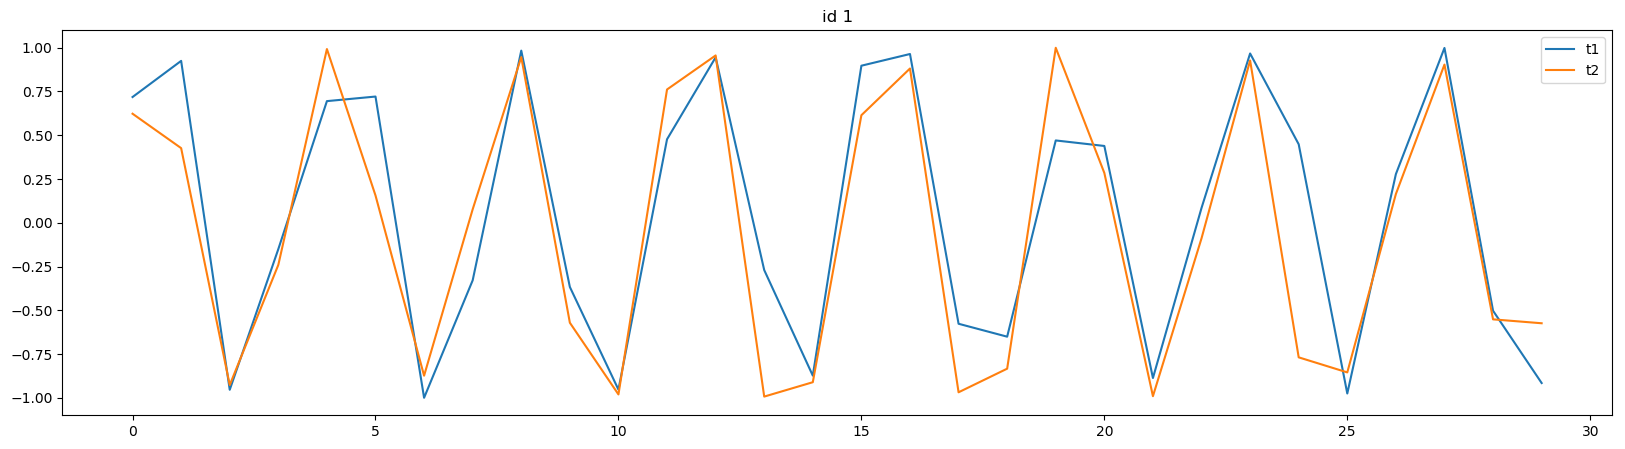

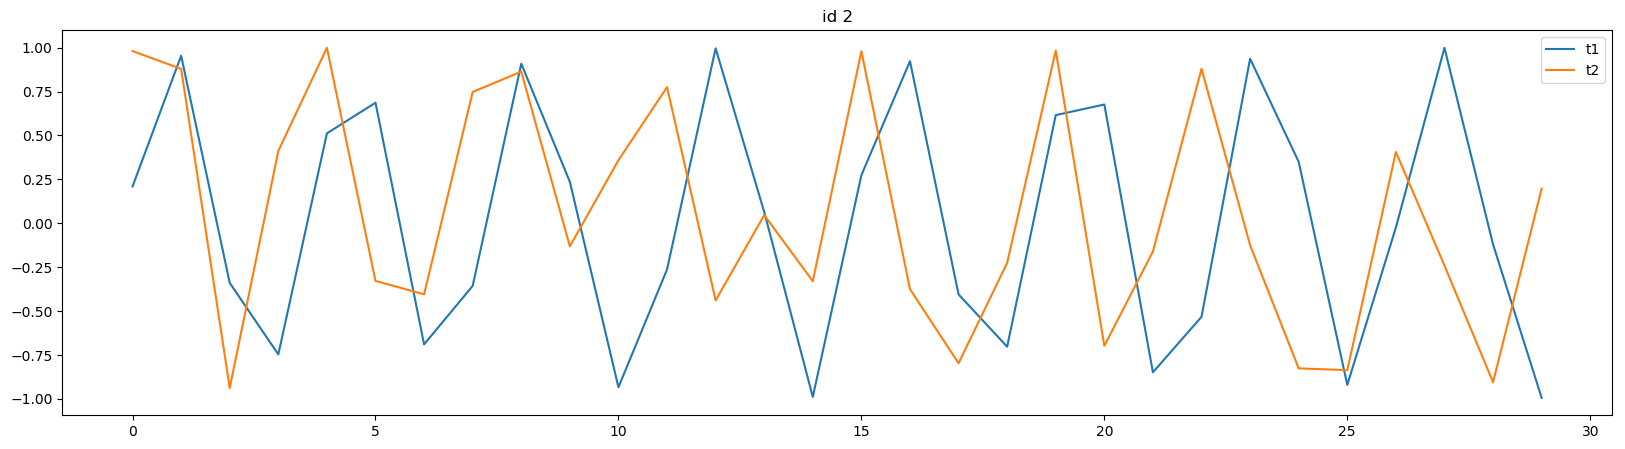

In [145]:
data[
    data['id'] == 1
].drop(['index', 'id'], axis=1).plot(
    kind='line',
    figsize=(20, 5),
    title='id 1'
);

data[
    data['id'] == 2
].drop(['index', 'id'], axis=1).plot(
    kind='line',
    figsize=(20, 5),
     title='id 2'
);

## Compute Betti numbers

### Entire time series

In [14]:
betti_numbers_df(
    df=data[
        data['id'] == 1
    ],
    epsilon_range=create_epsilon_range(n=100),
    max_simplex_dim=3,
    order_col='index',
    channels=['t1', 't2']
)

,epsilon,betti_0_t1,betti_0_t2,betti_1_t1,betti_1_t2,betti_2_t1,betti_2_t2
0,0,28,28,0,0,0.0,0
1,1,27,26,0,0,0.0,0
2,2,26,26,0,0,0.0,0
3,3,20,21,0,0,0.0,0
4,4,14,16,0,0,0.0,0
5,5,9,15,0,0,0.0,0
6,6,7,9,0,0,0.0,0
7,7,5,4,0,0,0.0,0
8,8,4,2,0,0,0.0,0
9,9,3,2,0,0,0.0,0


### Rolling Betti numbers

In [15]:
# compute rolling betti numbers for t1 and t2 just for id == 1

betti_channels = time_series_rolling_betti(
    df=data[data['id'] == 1],
    channels=['t1', 't2'],
    epsilon_range=create_epsilon_range(100),
    max_simplex_dim=3,
    window=10
)

In [287]:
betti_channels

,index,t1,t1_betti_0,t1_betti_1,t1_betti_2,t2,t2_betti_0,t2_betti_1,t2_betti_2
0,9,-0.366686,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.570911,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10,-0.952894,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.980382,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,11,0.476764,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.761122,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,12,0.944585,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.955510,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,13,-0.269978,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.992742,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,14,-0.873035,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.910646,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,15,0.896852,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.614155,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,16,0.963705,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.880870,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,17,-0.576808,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.968164,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,18,-0.650601,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.833334,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


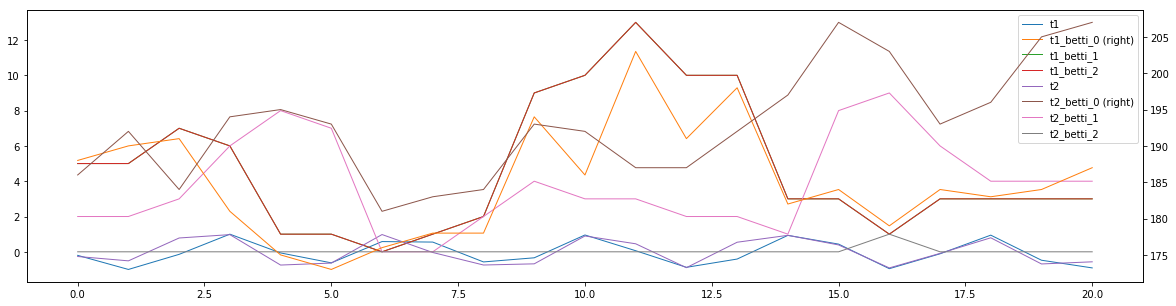

In [113]:
betti_channels.apply(lambda x: pd.Series({
    't1': x['t1'],
    't1_betti_0': sum(x['t1_betti_0']),
    't1_betti_1': sum(x['t1_betti_1']),
    't1_betti_2': sum(x['t1_betti_1']),
    't2': x['t2'],
    't2_betti_0': sum(x['t2_betti_0']),
    't2_betti_1': sum(x['t2_betti_1']),
    't2_betti_2': sum(x['t2_betti_2']),
}), axis=1).plot(
    kind='line',
    figsize=(20, 5),
    lw=1,
    secondary_y=['t1_betti_0', 't2_betti_0']
);

### Grouped by id

In [17]:
# compute rolling betti numbers for all ids

betti_channels_grouped = data.groupby('id').apply(
    lambda x: time_series_rolling_betti(
        df=x,
        channels=['t1', 't2'],
        epsilon_range=create_epsilon_range(100),
        max_simplex_dim=3,
        window=10
    )
)

In [18]:
betti_channels_grouped

index        t1                                         t1_betti_0  \
id                                                                          
1  0       9 -0.202153  [8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 5, 5, 4, 4, ...   
   1      10 -0.999378  [8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 4, 3, 3, ...   
   2      11 -0.143765  [8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 5, 5, 4, 4, ...   
   3      12  0.999456  [8, 8, 8, 7, 7, 7, 7, 7, 5, 5, 5, 5, 4, 4, 4, ...   
   4      13 -0.063769  [8, 8, 8, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, ...   
   5      14 -0.626267  [8, 8, 8, 6, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, ...   
   6      15  0.579841  [8, 8, 8, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, ...   
   7      16  0.551143  [8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 3, 3, 3, ...   
   8      17 -0.573515  [8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 5, 3, 2, 2, ...   
   9      18 -0.339904  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 2, ...   
   10     19  0.953349  [8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 6, 4, 4, 2, ...   
   11     20  0.061818  [8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, ...   
   12     21 -0.879104  [8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 4, 3, 3, ...   
   13     22 -0.410437  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 4, 4, 4, ...   
   14     23  0.931668  [8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 5, 4, 4, 4, 3, ...   
   15     24  0.436115  [8, 8, 8, 8, 8, 7, 6, 6, 6, 5, 5, 4, 4, 4, 3, ...   
   16     25 -0.955723  [8, 8, 8, 8, 8, 7, 5, 5, 4, 4, 4, 4, 4, 3, 3, ...   
   17     26 -0.112097  [8, 8, 8, 8, 8, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   18     27  0.944291  [8, 8, 8, 8, 8, 7, 5, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   19     28 -0.477420  [8, 8, 8, 8, 8, 7, 6, 5, 5, 5, 5, 5, 5, 4, 4, ...   
   20     29 -0.912195  [8, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 4, 4, ...   
2  0       9  0.400020  [8, 8, 8, 8, 8, 8, 8, 7, 7, 6, 4, 4, 4, 4, 4, ...   
   1      10 -0.983497  [8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 4, 4, 3, 3, 3, ...   
   2      11 -0.157747  [8, 8, 8, 8, 8, 8, 8, 7, 6, 4, 4, 4, 4, 4, 4, ...   
   3      12  0.996889  [8, 8, 8, 8, 8, 7, 7, 5, 5, 4, 4, 3, 3, 3, 3, ...   
   4      13  0.084923  [8, 8, 8, 8, 8, 7, 6, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   5      14 -0.997349  [8, 8, 8, 8, 8, 6, 5, 4, 4, 4, 4, 4, 4, 4, 3, ...   
   6      15  0.103741  [8, 8, 8, 8, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   7      16  0.907836  [8, 8, 8, 8, 7, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   8      17 -0.621923  [8, 8, 8, 8, 7, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, ...   
   9      18 -0.848000  [8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 4, 4, 3, 3, 3, ...   
   10     19  0.630721  [8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 5, 4, 3, 3, 3, ...   
   11     20  0.601735  [8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 5, 5, 4, 3, 2, ...   
   12     21 -0.642855  [8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 4, 3, 3, 2, ...   
   13     22 -0.509638  [8, 8, 8, 8, 8, 8, 8, 7, 7, 5, 5, 5, 5, 3, 3, ...   
   14     23  0.933572  [8, 8, 8, 8, 8, 8, 8, 6, 6, 4, 3, 3, 3, 3, 3, ...   
   15     24  0.445503  [8, 8, 8, 8, 8, 8, 8, 6, 5, 5, 4, 4, 4, 4, 4, ...   
   16     25 -0.937367  [8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   17     26 -0.371930  [8, 8, 8, 8, 8, 8, 7, 4, 4, 4, 4, 4, 4, 4, 4, ...   
   18     27  0.999921  [8, 8, 8, 8, 8, 6, 5, 4, 4, 4, 4, 4, 4, 4, 3, ...   
   19     28 -0.275430  [8, 8, 8, 8, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, ...   
   20     29 -0.971019  [8, 8, 8, 8, 8, 6, 6, 6, 6, 5, 3, 3, 3, 3, 3, ...   

                                              t1_betti_1  \
id                                                         
1  0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   3   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   5   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
   7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
   8   [0, 0, 0, 0

## PySpark

In [33]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession, DataFrame
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import array, struct
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import functions

from jinja2 import Template

In [77]:
def get_spark_session(configs={}):
    """Gets or creates SparkSession with the given configs
    Args:
        configs (dict): Key/value pairs of spark configs that will be passed to the SparkSession

    Returns:
        A SparkSession created with the given configs and app name
    """

    spark_conf = SparkConf()

    [spark_conf.set(k, configs[k]) for k in configs]

    return SparkSession.builder.config(conf=spark_conf).getOrCreate()

In [21]:
spark = get_spark_session()

In [22]:
HTML("<a href='{URL}' target='_blank'>Spark Job UI</a>".format(URL=spark.sparkContext.uiWebUrl))

### Generate fake data

In [23]:
n_steps = 30
rrand = [20, 30, 10, 60]
alpha = [0.6, 0.8, 0.2, 0.9]

d1 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[0], amp_noise=alpha[0]),
    't2': noisy_sine(n_steps, radial_noise=rrand[1], amp_noise=alpha[1]),
    'id': 1,
    'index': range(n_steps)
}

d2 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[2], amp_noise=alpha[2]),
    't2': noisy_sine(n_steps, radial_noise=rrand[3], amp_noise=alpha[3]),
    'id': 2,
    'index': range(n_steps)
}

In [24]:
data = pd.concat(objs=[pd.DataFrame(d1), pd.DataFrame(d2)])

In [26]:
data_sdf = spark.createDataFrame(data)
data_sdf.registerTempTable('data')

In [27]:
id_col = 'id'
order_col = 'index'
channels = ['t1', 't2']
window = 10

In [28]:
sql_template = """
WITH W as (
SELECT 
d1.{{id_col}},
{% for channel in channels %}
d1.{{channel}},
d2.{{channel}} as {{channel}}_wdw,
{% endfor %}
d1.{{order_col}},
d2.{{order_col}} as {{order_col}}_wdw,
d1.{{order_col}} - d2.{{order_col}} as {{order_col}}_difference,
count(d2.{{order_col}}) over(partition by d1.{{id_col}}, d1.{{order_col}}) as num_{{order_col}}_in_wdw
FROM data as d1
LEFT JOIN data as d2
ON d1.{{id_col}} = d2.{{id_col}}
    AND d1.{{order_col}} > d2.{{order_col}}
    AND d1.{{order_col}} - d2.{{order_col}} <= {{window}}
ORDER BY d1.{{id_col}} ASC, d1.{{order_col}} ASC, d1.{{order_col}} - d2.{{order_col}} DESC
)
SELECT
{{id_col}},
{{order_col}},
{{order_col}}_wdw,
{% for channel in channels %}
{{channel}},
{{channel}}_wdw {% if not loop.last %} , {% endif %}
{% endfor %}
FROM W
WHERE num_{{order_col}}_in_wdw = {{window}}
"""

sql = Template(
    sql_template
).render(
    id_col=id_col,
    order_col=order_col,
    channels=channels,
    window=window
)

In [29]:
data_windowed = spark.sql(sql)

In [30]:
data_windowed.show()

+---+-----+---------+-------------------+--------------------+--------------------+--------------------+
| id|index|index_wdw|                 t1|              t1_wdw|                  t2|              t2_wdw|
+---+-----+---------+-------------------+--------------------+--------------------+--------------------+
|  1|   10|        0|-0.8540921249811788|  0.8650066973298818| -0.9965314415076736| 0.30725569034870875|
|  1|   10|        1|-0.8540921249811788|  0.8799417542246405| -0.9965314415076736| 0.04740419236244142|
|  1|   10|        2|-0.8540921249811788|  -0.821512315108959| -0.9965314415076736| -0.9856545349691832|
|  1|   10|        3|-0.8540921249811788| -0.5784279312906544| -0.9965314415076736|-0.45461731228238283|
|  1|   10|        4|-0.8540921249811788|  0.7064189011028763| -0.9965314415076736|  0.9918227041733916|
|  1|   10|        5|-0.8540921249811788|  0.6544059864356543| -0.9965314415076736| 0.16156902089865788|
|  1|   10|        6|-0.8540921249811788| -0.7845172998

In [68]:
from pyspark.sql.types import *

max_simplex_dim = 3

schema = StructType(
    [StructField(id_col, LongType()), StructField(order_col, LongType())]
    +
    [StructField(channel, DoubleType()) for channel in channels]
    +
    [StructField('epsilon', DoubleType())]
    +
    [StructField('{CHANNEL}_betti_{DIM}'.format(CHANNEL=channel, DIM=dim), IntegerType()) for (channel, dim) in itertools.product(channels, range(max_simplex_dim))]
)

In [73]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def betti_numbers_spark(df):
    # compute homology
    epsilon_range = create_epsilon_range(100)
    hom_dict = {
      channel: time_series_to_persistent_homology(time_series=df[channel + '_wdw'].values, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim)
      for channel in channels
    }
    
    output_dict = {
        id_col : df[id_col].values[0],
        order_col : df[order_col].values[0],
        'epsilon': epsilon_range
    }
    
    output_hom_dict = {
      '{CHANNEL}_betti_{DIM}'.format(CHANNEL=channel, DIM=dim) : hom_dict[channel][dim]
      for (channel, dim) in itertools.product(channels, range(max_simplex_dim))
    }
    
    output_channels_dict = {
        channel: df[channel].values[0]
      for channel in channels
    }
    
    output_data_dict = dict(output_dict, **output_channels_dict, **output_hom_dict)
  
    return pd.DataFrame(
        data={key: output_data_dict[key] for key in schema.names}, # be careful to order the column names properly
        columns=schema.names
    )

In [74]:
betti_channels_sdf = data_windowed.groupby(id_col, order_col).apply(betti_numbers_spark)

In [75]:
betti_channels_df = betti_channels_sdf.toPandas()

In [78]:
betti_channels_df.sort_values([id_col, order_col])

,id,index,t1,t2,epsilon,t1_betti_0,t1_betti_1,t1_betti_2,t2_betti_0,t2_betti_1,t2_betti_2
2100,1,10,-0.854092,-0.996531,0.00,8,0,0,8,0,0
2101,1,10,-0.854092,-0.996531,0.01,8,0,0,7,0,0
2102,1,10,-0.854092,-0.996531,0.02,8,0,0,6,0,0
2103,1,10,-0.854092,-0.996531,0.03,8,0,0,6,0,0
2104,1,10,-0.854092,-0.996531,0.04,7,0,0,5,0,0
2105,1,10,-0.854092,-0.996531,0.05,7,0,0,5,0,0
2106,1,10,-0.854092,-0.996531,0.06,6,0,0,5,0,0
2107,1,10,-0.854092,-0.996531,0.07,5,0,0,5,0,0
2108,1,10,-0.854092,-0.996531,0.08,5,0,0,5,0,0
2109,1,10,-0.854092,-0.996531,0.09,5,0,0,4,0,0


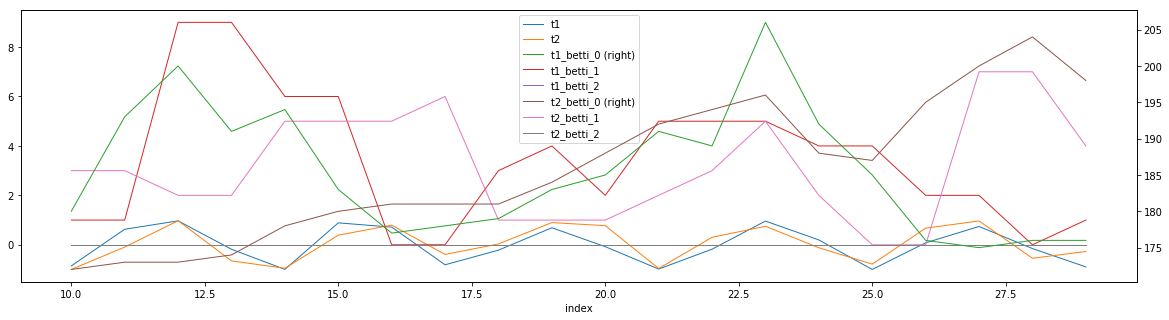

In [129]:
betti_channels_df[
    betti_channels_df['id'] == 1
].drop(['id', 'epsilon'], axis=1).groupby('index').agg({
    't1': 'max',
    't2': 'max',
    't1_betti_0': 'sum',
    't1_betti_1': 'sum',
    't1_betti_2': 'sum',
    't2_betti_0': 'sum',
    't2_betti_1': 'sum',
    't2_betti_2': 'sum',
}).plot(
    kind='line',
    figsize=(20, 5),
    lw=1,
    secondary_y=['t1_betti_0', 't2_betti_0']
);

# Computing Betti numbers using [Ripser](https://github.com/Ripser/ripser)

## Pandas

In [226]:
from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from ripser import Rips
import matplotlib.pyplot as plt
import random
import itertools
from functools import reduce

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [252]:
def rolling_window(a, window):
    '''
    Take in an array and return array of rolling windows of specified length
    
    Parameters:
    - a: numpy array that will be windowed
    - window: integer that will be the length of the window
    
    Returns:
    - a_windowed: array where each entry is an array of length window
    '''
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    a_windowed = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_windowed

In [253]:
def time_series_to_point_cloud(time_series, dimension_embed=2):
    '''
    Convert a time series into a point cloud in the dimension specified by dimension_embed
    
    Parameters:
    - time_series: numpy array of time series values
    - dimension_embed: dimension of Euclidean space in which to embed the time series into by taking windows of dimension_embed length,
        e.g. if the time series is [t_1,...,t_n] and dimension_embed is 2, then the point cloud would be [(t_0, t_1), (t_1, t_2),...,(t_(n-1), t_n)]
        
    Returns:
    - point_cloud: collection of points embedded into Euclidean space of dimension = dimension_embed, constructed
    in the manner explained above
    '''

    assert len(time_series) >= dimension_embed, 'dimension_embed larger than length of time_series'
    
    # time series to float type
    time_series = np.array(time_series)
    time_series = time_series.astype(float)

    # compute point cloud
    point_cloud = rolling_window(a=time_series, window=dimension_embed)
    
    return np.array(point_cloud)

In [309]:
def point_cloud_to_persistent_cohomology_ripser(point_cloud, epsilon_range, max_simplex_dim):
    # ensure epsilon_range is a numpy array
    epsilon_range = np.array(epsilon_range)

    # build filtration
    filtration = Rips(maxdim=max_simplex_dim, thresh=-1, coeff=2, do_cocycles=False, verbose=False);
    
    # initialize persistence diagrams
    diagrams = filtration.fit_transform(point_cloud)
    
    # normalize epsilon distance in diagrams so max is 1
    diagrams = [np.array([dg for dg in diag if np.isfinite(dg).all()]) for diag in diagrams]
    diagrams = diagrams / max([np.array([dg for dg in diag if np.isfinite(dg).all()]).max() for diag in diagrams if diag.shape[0] > 0])
    
    ep_ran_len = len(epsilon_range)
    
    homology = {dimension: np.zeros(ep_ran_len).tolist() for dimension in range(max_simplex_dim+1)}

    for dimension, diagram in enumerate(diagrams):
        if dimension <= max_simplex_dim and len(diagram) > 0:
            homology[dimension] = np.array([np.array(((epsilon_range >= point[0]) & (epsilon_range <= point[1])).astype(int)) 
                                        for point in diagram
                                       ]).sum(axis=0).tolist()
        
    return homology

In [310]:
def time_series_to_persistent_cohomology_ripser(time_series, epsilon_range, max_simplex_dim):
    '''
    Wrapper function that takes in a time series and outputs
    the persistent homology object, along with other
    auxiliary objects.
    
    Parameters: 
    - time_series: Numpy array of time series values
    - epsilon_range: Numpy array of epsilon values between 0 and 1 at which to extract betti numbers.
    - max_simplex_dim: Integer denoting the maximum dimension of simplexes to create in filtration
    
    Returns:
    - homology: dictionary with keys in range(max_simplex_dim) and, the value hom[i] is an array of length 
    equal to len(epsilon_range) containing the betti numbers of the i-th homology groups for the Rips filtration
    '''
    
    # create point cloud from time series
    point_cloud = time_series_to_point_cloud(time_series, dimension_embed=max_simplex_dim)

    homology = point_cloud_to_persistent_cohomology_ripser(point_cloud=point_cloud, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim-1)
    return homology

In [311]:
def time_series_rolling_betti_ripser(df, channels, epsilon_range, max_simplex_dim, window):
    betti_channels = {}
    for channel in channels:
        betti_channels[channel] = [
            time_series_to_persistent_cohomology_ripser(
                time_series=wdw,
                epsilon_range=epsilon_range,
                max_simplex_dim=max_simplex_dim
            )
            for wdw in rolling_window(df[channel].values, window)
        ]
        
        betti_channels[channel] = pd.concat(
            objs=[
                pd.Series(df[channel].index[window-1:], index=df[channel].index[window-1:], name='index'),
                df[channel][window-1:],
                pd.DataFrame(
                    data=betti_channels[channel],
                    index=df[channel].index[window-1:]
                ).rename(columns={n: '{CHANNEL}_betti_'.format(CHANNEL=channel) + str(n) for n in range(max_simplex_dim+1)})
            ],
            axis=1
        )

    return reduce(lambda left, right: pd.merge(left, right, on='index'), [betti_channels[channel] for channel in channels])

### Generate fake data

In [312]:
n_steps = 30
rrand = [20, 30, 10, 60]
alpha = [0.6, 0.8, 0.2, 0.9]

d1 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[0], amp_noise=alpha[0]),
    't2': noisy_sine(n_steps, radial_noise=rrand[1], amp_noise=alpha[1]),
    'id': 1,
    'index': range(n_steps)
}

d2 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[2], amp_noise=alpha[2]),
    't2': noisy_sine(n_steps, radial_noise=rrand[3], amp_noise=alpha[3]),
    'id': 2,
    'index': range(n_steps)
}

### Rolling Betti numbers

In [313]:
# compute rolling betti numbers for t1 and t2 just for id == 1

betti_channels = time_series_rolling_betti_ripser(
    df=data[data['id'] == 1],
    channels=['t1', 't2'],
    epsilon_range=create_epsilon_range(100),
    max_simplex_dim=3,
    window=10
)

In [314]:
betti_channels

,index,t1,t1_betti_0,t1_betti_1,t1_betti_2,t2,t2_betti_0,t2_betti_1,t2_betti_2
0,9,-0.366686,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.570911,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10,-0.952894,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.980382,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,11,0.476764,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.761122,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,12,0.944585,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.955510,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,13,-0.269978,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.992742,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,14,-0.873035,"[7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.910646,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,15,0.896852,"[7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.614155,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,16,0.963705,"[7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.880870,"[7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,17,-0.576808,"[7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.968164,"[7, 7, 7, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,18,-0.650601,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.833334,"[7, 7, 7, 7, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


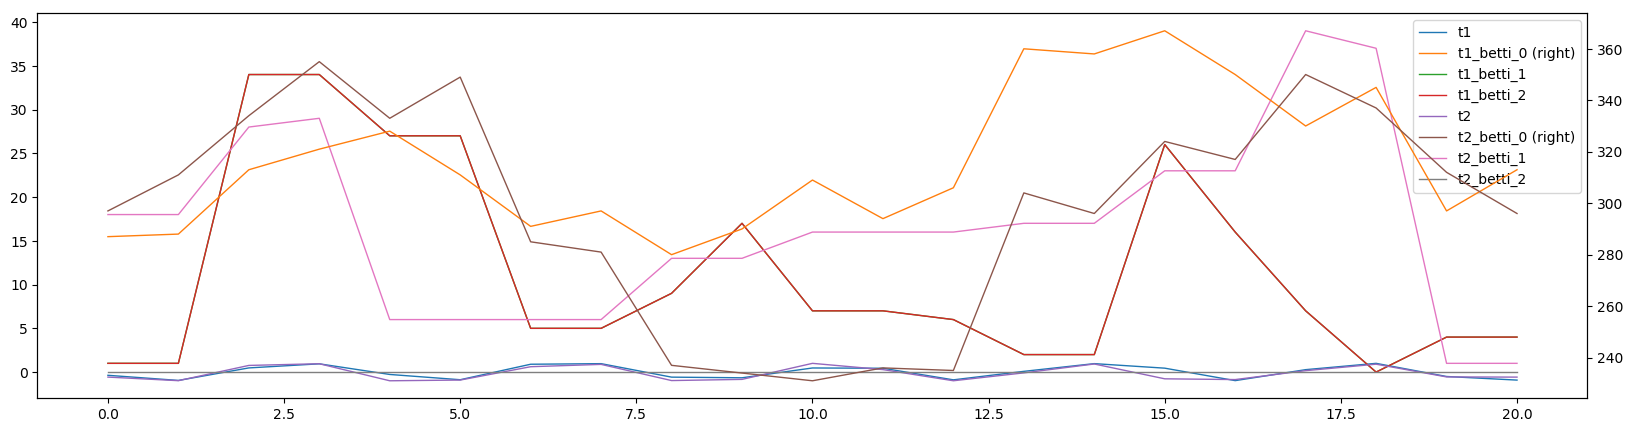

In [315]:
betti_channels.apply(lambda x: pd.Series({
    't1': x['t1'],
    't1_betti_0': sum(x['t1_betti_0']),
    't1_betti_1': sum(x['t1_betti_1']),
    't1_betti_2': sum(x['t1_betti_1']),
    't2': x['t2'],
    't2_betti_0': sum(x['t2_betti_0']),
    't2_betti_1': sum(x['t2_betti_1']),
    't2_betti_2': sum(x['t2_betti_2']),
}), axis=1).plot(
    kind='line',
    figsize=(20, 5),
    lw=1,
    secondary_y=['t1_betti_0', 't2_betti_0']
);

## PySpark

In [316]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession, DataFrame
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import array, struct
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import functions

from jinja2 import Template

In [317]:
def get_spark_session(configs={}):
    """Gets or creates SparkSession with the given configs
    Args:
        configs (dict): Key/value pairs of spark configs that will be passed to the SparkSession

    Returns:
        A SparkSession created with the given configs and app name
    """

    spark_conf = SparkConf()

    [spark_conf.set(k, configs[k]) for k in configs]

    return SparkSession.builder.config(conf=spark_conf).getOrCreate()

In [318]:
spark = get_spark_session()

In [319]:
HTML("<a href='{URL}' target='_blank'>Spark Job UI</a>".format(URL=spark.sparkContext.uiWebUrl))

### Generate fake data

In [320]:
n_steps = 30
rrand = [20, 30, 10, 60]
alpha = [0.6, 0.8, 0.2, 0.9]

d1 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[0], amp_noise=alpha[0]),
    't2': noisy_sine(n_steps, radial_noise=rrand[1], amp_noise=alpha[1]),
    'id': 1,
    'index': range(n_steps)
}

d2 = {
    't1': noisy_sine(n_steps, radial_noise=rrand[2], amp_noise=alpha[2]),
    't2': noisy_sine(n_steps, radial_noise=rrand[3], amp_noise=alpha[3]),
    'id': 2,
    'index': range(n_steps)
}

In [321]:
data = pd.concat(objs=[pd.DataFrame(d1), pd.DataFrame(d2)])

In [322]:
data_sdf = spark.createDataFrame(data)
data_sdf.registerTempTable('data')

In [323]:
id_col = 'id'
order_col = 'index'
channels = ['t1', 't2']
window = 10

In [324]:
sql_template = """
WITH W as (
SELECT 
d1.{{id_col}},
{% for channel in channels %}
d1.{{channel}},
d2.{{channel}} as {{channel}}_wdw,
{% endfor %}
d1.{{order_col}},
d2.{{order_col}} as {{order_col}}_wdw,
d1.{{order_col}} - d2.{{order_col}} as {{order_col}}_difference,
count(d2.{{order_col}}) over(partition by d1.{{id_col}}, d1.{{order_col}}) as num_{{order_col}}_in_wdw
FROM data as d1
LEFT JOIN data as d2
ON d1.{{id_col}} = d2.{{id_col}}
    AND d1.{{order_col}} > d2.{{order_col}}
    AND d1.{{order_col}} - d2.{{order_col}} <= {{window}}
ORDER BY d1.{{id_col}} ASC, d1.{{order_col}} ASC, d1.{{order_col}} - d2.{{order_col}} DESC
)
SELECT
{{id_col}},
{{order_col}},
{{order_col}}_wdw,
{% for channel in channels %}
{{channel}},
{{channel}}_wdw {% if not loop.last %} , {% endif %}
{% endfor %}
FROM W
WHERE num_{{order_col}}_in_wdw = {{window}}
"""

sql = Template(
    sql_template
).render(
    id_col=id_col,
    order_col=order_col,
    channels=channels,
    window=window
)

In [325]:
data_windowed = spark.sql(sql)

In [326]:
data_windowed.show()

+---+-----+---------+------------------+--------------------+--------------------+--------------------+
| id|index|index_wdw|                t1|              t1_wdw|                  t2|              t2_wdw|
+---+-----+---------+------------------+--------------------+--------------------+--------------------+
|  1|   10|        0|-0.897937639237329|  0.7344096505418616|  -0.989645794755333|  0.9685501471373461|
|  1|   10|        1|-0.897937639237329|  0.7789351909146233|  -0.989645794755333| 0.36639123805775736|
|  1|   10|        2|-0.897937639237329| -0.7234524363188582|  -0.989645794755333| -0.7292184658904135|
|  1|   10|        3|-0.897937639237329|-0.21030765104494276|  -0.989645794755333|-0.41590480088595805|
|  1|   10|        4|-0.897937639237329|  0.7712189086411776|  -0.989645794755333|  0.9776549218662646|
|  1|   10|        5|-0.897937639237329|   0.525206016992622|  -0.989645794755333| -0.2815420116943966|
|  1|   10|        6|-0.897937639237329| -0.9826866937668676|  -

In [327]:
from pyspark.sql.types import *

max_simplex_dim = 3

schema = StructType(
    [StructField(id_col, LongType()), StructField(order_col, LongType())]
    +
    [StructField(channel, DoubleType()) for channel in channels]
    +
    [StructField('epsilon', DoubleType())]
    +
    [StructField('{CHANNEL}_betti_{DIM}'.format(CHANNEL=channel, DIM=dim), IntegerType()) for (channel, dim) in itertools.product(channels, range(max_simplex_dim))]
)

In [329]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def betti_numbers_ripser_spark(df):
    # compute homology
    epsilon_range = create_epsilon_range(100)
    hom_dict = {
      channel: time_series_to_persistent_cohomology_ripser(time_series=df[channel + '_wdw'].values, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim)
      for channel in channels
    }
    
    output_dict = {
        id_col : df[id_col].values[0],
        order_col : df[order_col].values[0],
        'epsilon': epsilon_range
    }
    
    output_hom_dict = {
      '{CHANNEL}_betti_{DIM}'.format(CHANNEL=channel, DIM=dim) : hom_dict[channel][dim]
      for (channel, dim) in itertools.product(channels, range(max_simplex_dim))
    }
    
    output_channels_dict = {
        channel: df[channel].values[0]
      for channel in channels
    }
    
    output_data_dict = dict(output_dict, **output_channels_dict, **output_hom_dict)
  
    return pd.DataFrame(
        data={key: output_data_dict[key] for key in schema.names}, # be careful to order the column names properly
        columns=schema.names
    )

In [330]:
betti_channels_sdf = data_windowed.groupby(id_col, order_col).apply(betti_numbers_ripser_spark)

In [331]:
betti_channels_df = betti_channels_sdf.toPandas()

In [332]:
betti_channels_df.sort_values([id_col, order_col])

,id,index,t1,t2,epsilon,t1_betti_0,t1_betti_1,t1_betti_2,t2_betti_0,t2_betti_1,t2_betti_2
2100,1,10,-0.897938,-0.989646,0.00,7,0,0,7,0,0
2101,1,10,-0.897938,-0.989646,0.01,7,0,0,7,0,0
2102,1,10,-0.897938,-0.989646,0.02,7,0,0,7,0,0
2103,1,10,-0.897938,-0.989646,0.03,7,0,0,7,0,0
2104,1,10,-0.897938,-0.989646,0.04,7,0,0,7,0,0
2105,1,10,-0.897938,-0.989646,0.05,7,0,0,7,0,0
2106,1,10,-0.897938,-0.989646,0.06,7,0,0,7,0,0
2107,1,10,-0.897938,-0.989646,0.07,7,0,0,7,0,0
2108,1,10,-0.897938,-0.989646,0.08,7,0,0,7,0,0
2109,1,10,-0.897938,-0.989646,0.09,7,0,0,7,0,0


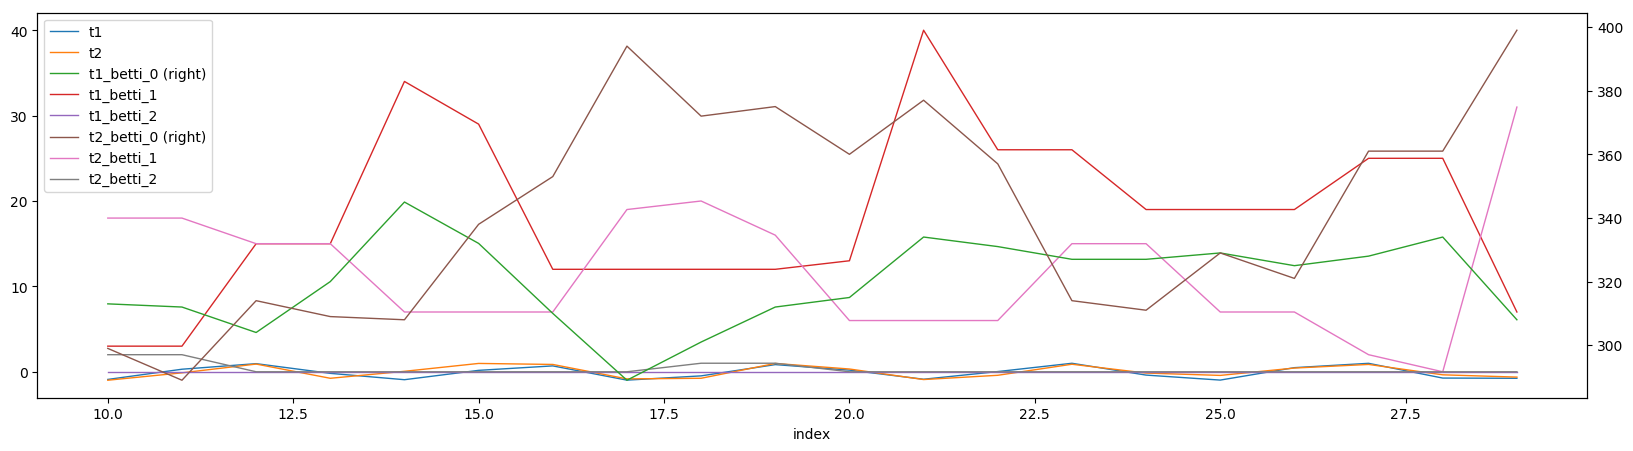

In [333]:
betti_channels_df[
    betti_channels_df['id'] == 1
].drop(['id', 'epsilon'], axis=1).groupby('index').agg({
    't1': 'max',
    't2': 'max',
    't1_betti_0': 'sum',
    't1_betti_1': 'sum',
    't1_betti_2': 'sum',
    't2_betti_0': 'sum',
    't2_betti_1': 'sum',
    't2_betti_2': 'sum',
}).plot(
    kind='line',
    figsize=(20, 5),
    lw=1,
    secondary_y=['t1_betti_0', 't2_betti_0']
);